## **Lab 5:** Transfer Learning for Object Detection and Semantic Segmentation

**Objectives**
- Load and run inference with a pre-trained object detection network (e.g., Faster R-CNN).
- Load and run inference with a pre-trained semantic segmentation network (e.g., DeepLabV3).
- Visualise bounding boxes, class labels, and segmentation masks on real images.
- Perform basic transfer learning (fine-tuning or feature extraction) on a small custom dataset.
- Compare detection vs segmentation outputs and discuss trade-offs.

**Reading**

- PyTorch torchvision detection tutorial or Detectron2 documentation.

**Instructions:**
> - Ensure your Python environment is setup correctly, in particular Jupyter package is installed.<br>As we progress through this module, you may be required to install additional packages.
> - Prior to this tutorial, read the entire notebook and attempt all coding exercises.
> - To complete the coding exercises, write some python code between<br>`### INPUT YOUR CODE HERE ###` and `### END OF YOUR CODE SEGMENT ###`.<br> Use provided hints where necessary. We will generally provide a rough estimate of the number of lines to write.
> - Run cells by pressing `Shift+Enter` and verify that your results are consistent with unit tests.
> - Submit completed notebook on VLE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, data, exposure, transform, filters, util, metrics, feature
import cv2
from scipy.signal import convolve2d
from scipy.ndimage import uniform_filter
from PIL import Image

import torch
import torch.nn.functional as F
from tqdm import tqdm  # progress bar library
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="Expected in:")
warnings.filterwarnings("ignore", message="libtorch_cpu.dylib")

print("Library versions:")
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("cv2:", cv2.__version__)
print("pytorch:", torch.__version__)

# TODO: confirm you can run this cell without errors.

Library versions:
numpy: 2.0.2
matplotlib: 3.10.0
cv2: 4.12.0
pytorch: 2.9.0+cu126


> **Expected Output:**
>
> ``` text
> Library versions:
> numpy: 1.26.4
> matplotlib: 3.7.2
> cv2: 4.10.0
> pytorch: 2.1.0
> ```

In [2]:
import random

random.seed(2025)
# --- NumPy ---
np.random.seed(2025)
# --- PyTorch (CPU + GPU) ---
torch.manual_seed(2025)
torch.cuda.manual_seed(2025)

---

## <font color='#D85658'>1. Introduction and Setup</font> ##

Import pretrained models from `torchvision` or `Detectron2`, Load a few sample images (from COCO, Pascal VOC, or user-uploaded).

In this first exercise, we’ll prepare our environment for transfer learning experiments in **object detection** and **semantic segmentation**.

We will:
1. Import pretrained models from `torchvision` (or Detectron2 if available).  
2. Load and visualize a few sample images (from COCO, Pascal VOC, or user-uploaded).  
3. Prepare these images for inference.

> ### <mark style="background-color: cyan;">Exercise 1:</mark> Import Required Libraries

Here we import `torch`, `torchvision`, and helper utilities. We’ll also import pretrained models for detection and segmentation.

In [3]:
# --- Core libraries ---
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# --- Check for GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


> **Expected Output:**
>
> ``` text
> Using device: cuda
> ```

In [4]:
# --- Import pretrained models ---
# Faster R-CNN for object detection
### START CODE ### (1 line)
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model_detection = fasterrcnn_resnet50_fpn(weights="DEFAULT") # Faster R-CNN model with a ResNet-50-FPN backbone
### END CODE ###

model_detection.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

> **Expected Output:**
>
> ``` text
> FasterRCNN(
>  (transform): GeneralizedRCNNTransform(
>      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
>      Resize(min_size=(800,), max_size=1333, mode='bilinear')
>  )
>  (backbone): BackboneWithFPN(
>    (body): IntermediateLayerGetter(
>      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
>      (bn1): FrozenBatchNorm2d(64, eps=0.0)
>      (relu): ReLU(inplace=True)
>      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
>      (layer1): Sequential(
>        (0): Bottleneck(
>          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
>          (bn1): FrozenBatchNorm2d(64, eps=0.0)
>          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
>          (bn2): FrozenBatchNorm2d(64, eps=0.0)
>          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>          (bn3): FrozenBatchNorm2d(256, eps=0.0)
>          (relu): ReLU(inplace=True)
>          (downsample): Sequential(
>            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>            (1): FrozenBatchNorm2d(256, eps=0.0)
>          )
>        )
>      ... ...
> ```

In [5]:
# --- Import pretrained models ---
# DeepLabV3 for semantic segmentation
### START CODE ### (1 line)
from torchvision.models.segmentation import deeplabv3_resnet50

model_segmentation = deeplabv3_resnet50(weights="DEFAULT")  # DeepLabV3 model with a ResNet-50 backbone.
### END CODE ###
model_segmentation.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

> **Expected Output:**
>
> ``` text
> DeepLabV3(
>  (backbone): IntermediateLayerGetter(
>    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
>    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
>    (relu): ReLU(inplace=True)
>    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
>    (layer1): Sequential(
>      (0): Bottleneck(
>        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
>        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
>        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
>        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
>        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
>        (relu): ReLU(inplace=True)
>        (downsample): Sequential(
>          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
>        )
>      )
>      ... ...
> ```

- **Faster R-CNN** – for object detection (bounding boxes & class labels).
- **DeepLabV3** – for semantic segmentation (pixel-level classification).

> ### <mark style="background-color: cyan;">Exercise 2:</mark> Load Sample Images

We’ll now load a few images to test the pretrained models. You can use sample URLs, load from disk, or let students upload their own.

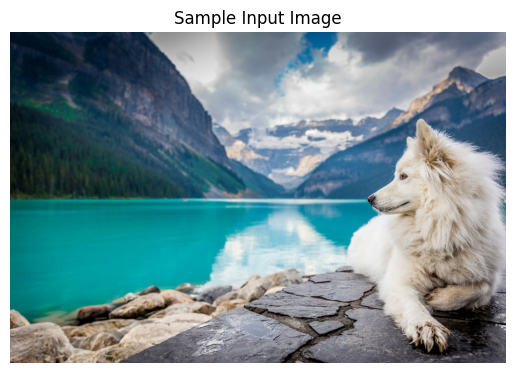

In [6]:
# --- Option 1: Load a sample image from the web ---
url = "https://images.unsplash.com/photo-1504208434309-cb69f4fe52b0"  # example street scene
response = requests.get(url)
### START CODE ### (1 line)
img = Image.open(BytesIO(response.content)).convert("RGB") # Load the image in "RGB" format
### END CODE ###

# --- Display the image ---
plt.imshow(img)
plt.title("Sample Input Image")
plt.axis("off")
plt.show()

> **Expected Output:**
>
> <img src="figs-lab5/example_img.png" alt="Expected Output" width="20%">
>

> ### <mark style="background-color: cyan;">Exercise 3:</mark> Preprocess Image for Model Inference

Before feeding images to a pretrained model, we need to normalize and convert them into PyTorch tensors.

In [7]:
# --- Define standard preprocessing pipeline ---

### START CODE ###
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
])

# --- Apply transformation ---
input_tensor = transform(img)                 # input_tensor shape: [3, H, W]
input_batch = input_tensor.unsqueeze(0)       # create batch dimension. input_batch shape: [1, 3, H, W]
### END CODE ###


#### Run a Quick Forward Pass

We can verify everything is working by running one forward pass through the detection model.

In [8]:
# --- Perform inference with Faster R-CNN ---
with torch.no_grad():
    ### START CODE ###
    predictions = model_detection(input_batch)[0]  # model_detection
    ### END CODE ###

# --- Inspect predicted boxes and labels ---
print("Detected objects:", len(predictions["boxes"]))
print("First 3 class IDs:", predictions["labels"][:3].tolist())
print("First 3 confidence scores:", predictions["scores"][:3].tolist())


Detected objects: 5
First 3 class IDs: [18, 23, 23]
First 3 confidence scores: [0.9962621331214905, 0.09108587354421616, 0.07058753818273544]


> **Expected Output:**
>
> Detected objects: 5
>
> First 3 class IDs: [18, 23, 23]
>
> First 3 confidence scores: [0.9962375164031982, 0.08851096779108047, 0.07258385419845581]
>

---

## <font color='#D85658'>2. Pre-trained Inference</font> ##

Pretrained models allow us to leverage powerful neural networks trained on large datasets (like COCO or ImageNet) without starting from scratch. In this section, you’ll perform inference using these models to automatically detect objects and segment scenes in new images.

> ### <mark style="background-color: cyan;">Exercise 4:</mark> Run Inference with Faster R-CNN

We’ll now run inference with the pretrained Faster R-CNN and visualize the detected objects directly on the image using bounding boxes and class labels.

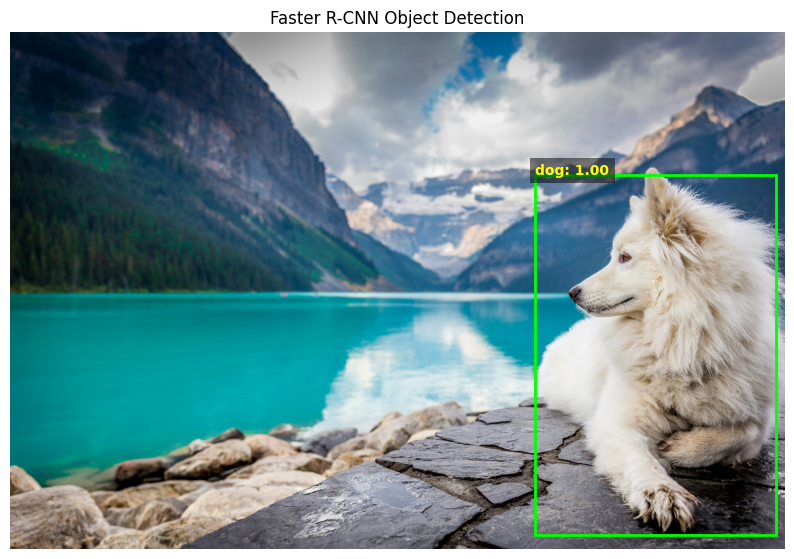

In [9]:
import matplotlib.patches as patches
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

### START CODE ###
# --- Get category labels for COCO dataset ---
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT  # Faster R-CNN model with a ResNet-50-FPN backbone
coco_labels = weights.meta["categories"]
### END CODE ###

# --- Run inference on the image ---
model_detection.eval()
with torch.no_grad():
    ### START CODE ###
    predictions = model_detection(input_batch)[0]
    ### END CODE ###

# --- Extract predicted boxes, labels, and confidence scores ---
### START CODE ###
boxes = predictions["boxes"]
labels = predictions["labels"]
scores = predictions["scores"]
### END CODE ###

# --- Display results ---
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(img)
ax.set_title("Faster R-CNN Object Detection")
ax.axis("off")

# --- Draw bounding boxes for high-confidence detections ---
threshold = 0.6  # confidence threshold
for box, label, score in zip(boxes, labels, scores):
    if score >= threshold:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{coco_labels[label]}: {score:.2f}",
                color='yellow', fontsize=10, weight='bold',
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

plt.show()


> **Expected Output:**
>
> <img src="figs-lab5/prediction.png" alt="Expected Output" width="20%">
>

> ### <mark style="background-color: cyan;">Exercise 5:</mark> Run Inference with DeepLabV3

We’ll now run inference with the pretrained DeepLabV3 and visualize the detected objects directly on the image using overlay class masks.

We use a pretrained DeepLabV3 model trained on the COCO dataset. This model predicts a segmentation mask where each pixel belongs to a class such as “person”, “car”, or “dog”.

In [10]:
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

# --- Load pretrained DeepLabV3 model ---
### START CODE ###
weights = DeepLabV3_ResNet50_Weights.DEFAULT  # DeepLabV3 default weights
model_seg = deeplabv3_resnet50(weights=weights)  # Load DeepLabV3 model (with a ResNet-50 backbone)
model_seg.eval()
### END CODE ###

# --- Use the same preprocessing transform as the model expects ---
preprocess = weights.transforms()

# --- Load or reuse the same sample image ---
### START CODE ###
img_tensor = preprocess(img).unsqueeze(0)  # add batch dimension -> [1, 3, H, W]
### END CODE ###


We perform a forward pass through the model to get per-pixel class predictions, then extract the segmentation mask.

In [11]:
# --- Run inference ---
with torch.no_grad():
    ### START CODE ###
    output = model_seg(img_tensor)["out"]  # model returns a dict with "out" key
    ### END CODE ###

# --- Get predicted class per pixel (argmax over channels) ---
### START CODE ###
pred_mask = output.argmax(1).squeeze(0)  # [H, W]
### END CODE ###


#### Visualize Segmentation Overlay

We’ll now overlay the segmentation mask on the original image using colors for each predicted class.

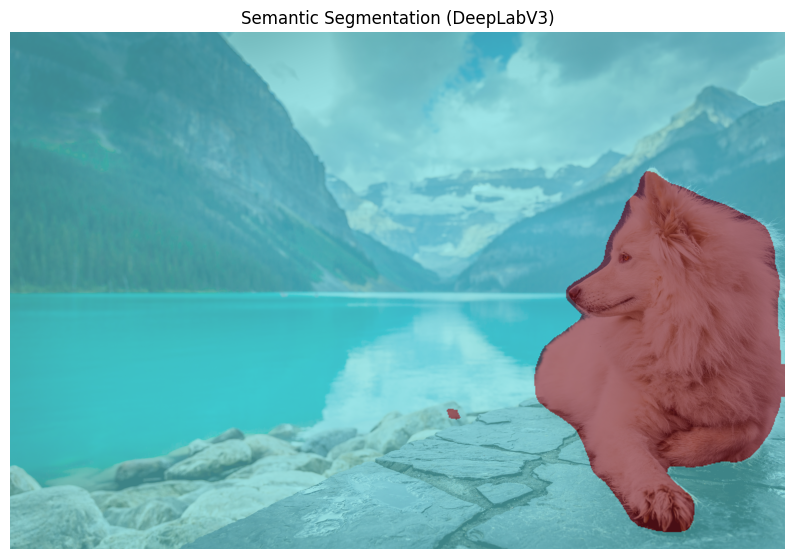

In [12]:
# --- Use model's built-in color palette for visualization ---
# This palette maps each class ID to a color
colors = np.array(weights.meta["categories"])
num_classes = len(weights.meta["categories"])

# --- Generate a random colormap for visualizing mask ---
np.random.seed(42)
palette = np.random.randint(0, 255, (num_classes, 3), dtype=np.uint8)

# --- Create colorized segmentation mask ---
color_mask = palette[pred_mask % num_classes]

### START CODE ###
# --- Convert mask to a PIL image and resize to match original image ---
mask_img = Image.fromarray(color_mask).resize(img.size)
# --- Blend segmentation mask with the original image ---
blended = Image.blend(
    img.convert("RGBA"),
    mask_img.convert("RGBA"),
    alpha=0.6
) # convert img and mask_img to "RGBA". blend them with alpha = 0.6
### END CODE ###

# --- Display results ---
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(blended)
ax.set_title("Semantic Segmentation (DeepLabV3)")
ax.axis("off")

plt.show()

> **Expected Output:**
>
> <img src="figs-lab5/semantic.png" alt="Expected Output" width="20%">
>

---
## <font color='#D85658'>3. Transfer Learning</font> ##

Pretrained models already know general visual features (edges, textures, shapes) learned from large datasets like COCO or ImageNet.  
By reusing these features and retraining only the final layers on a smaller dataset, we can **achieve good performance quickly** — this is called *transfer learning*.

In this section, you will:
1. Create a small custom dataset (e.g., from Oxford-IIIT Pet dataset).  
2. Fine-tune a pretrained model for a few epochs.  
3. Compare **feature extraction** (frozen backbone) vs **full fine-tuning** (all layers trainable).

> ### <mark style="background-color: cyan;">Exercise 6:</mark> Load and Prepare a Small Custom Dataset

We’ll use a small subset of CIFAR-10 as our "custom dataset." For simplicity, we’ll repurpose it as a mini classification task with 3–4 categories.

In [13]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset, random_split
import os

In [14]:
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

### START CODE ###
# # --- Preprocessing using pretrained weights ---
weights = DeepLabV3_ResNet50_Weights.DEFAULT  # Load DeepLabV3 model (with a ResNet-50 backbone)
preprocess = weights.transforms()
### END CODE ###

### START CODE ###
# --- Define image transformations ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),        # resize to fit pretrained models
    transforms.ToTensor()                # convert image to tensor
])
### END CODE ###

### START CODE ###
# Mask preprocessing (shift labels from {1,2,3} → {0,1,2})
def preprocess_mask(mask):
    mask = np.array(mask)
    mask = mask - 1              # shift all labels down by 1
    mask = np.clip(mask, 0, 2)   # ensure values stay within [0,2]
    return torch.tensor(mask, dtype=torch.long)
### END CODE ###

target_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to fit pretrained models
    transforms.Lambda(preprocess_mask)
])

root = "."

# --- Load Oxford-IIIT Pet segmentation dataset ---
full_dataset = datasets.OxfordIIITPet(
    root=".",
    split="trainval",
    ### END CODE ###

    target_types="segmentation",
    download=True,

    ### START CODE ###
    transform=transform,
    target_transform=target_transform
    ### END CODE ###
)

> **Expected Output:**
>
> ``` text
> Downloading https://thor.robots.ox.ac.uk/pets/images.tar.gz to oxford-iiit-pet/images.tar.gz
> 100%|██████████| 791918971/791918971 [01:45<00:00, 7484428.26it/s]
> Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet
> Downloading https://thor.robots.ox.ac.uk/pets/annotations.tar.gz to oxford-iiit-pet/annotations.tar.gz
> 100%|██████████| 19173078/19173078 [00:02<00:00, 8261212.72it/s]
> Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet
> ```

In [15]:
# --- Randomly subset the dataset to max 500 images ---
max_samples = 500
indices = random.sample(range(len(full_dataset)), max_samples)
### START CODE ###
small_dataset = torch.utils.data.Subset(full_dataset, indices)
### END CODE ###

# --- Split into train/val sets (80% train / 20% val) ---
### START CODE ###
train_size = int(0.8 * len(small_dataset))
val_size = len(small_dataset) - train_size
train_subset, val_subset = random_split(small_dataset, [train_size, val_size])
### END CODE ###

# --- DataLoaders ---
trainloader = DataLoader(train_subset, batch_size=2, shuffle=True)
valloader = DataLoader(val_subset, batch_size=2, shuffle=False)

print(f"Training samples: {len(train_subset)}, Validation samples: {len(val_subset)}")


Training samples: 400, Validation samples: 100


> **Expected Output:**
>
> ``` text
> Training samples: 400, Validation samples: 100
> ```

> ### <mark style="background-color: cyan;">Exercise 7:</mark> Load a Pretrained Model for Transfer Learning

We'll use a pretrained DeepLabV3 model. Then we'll replace its classification head to match our new dataset (4 classes).

In [16]:
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import torch.nn as nn

### START CODE ###
# --- Load pretrained DeepLabV3 ---
# --- Preprocessing using pretrained weights ---
weights = DeepLabV3_ResNet50_Weights.DEFAULT  # Load DeepLabV3 model (with a ResNet-50 backbone)
deeplabv3_model_1 = deeplabv3_resnet50(weights=weights)
### END CODE ###

# --- Oxford-IIIT Pet has 3 segmentation classes (background, pet, outline) ---
num_classes = 3
### START CODE ###
deeplabv3_model_1.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
### END CODE ###

# --- Move to GPU if available ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplabv3_model_1 = deeplabv3_model_1.to(device)


Build a function for model traninng.

In [17]:
def train_segmentation(model, dataloader, optimizer, criterion, num_epochs=2, device="cpu", mode="Feature Extraction"):
    """
    Train a semantic segmentation model (e.g., DeepLabV3) with a progress bar.
    """

    print(f"🚀 Training Mode: {mode}")
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        progress = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, masks in progress:

            ### START CODE ###
            # --- Move data to the correct device (GPU or CPU) ---
            images, masks = images.to(device), masks.to(device)

            # --- Reset gradient buffers before each iteration ---
            optimizer.zero_grad()

            # --- Forward pass: compute model predictions ---
            outputs = model(images)["out"]  # DeepLabV3 returns a dict with key "out"

            # --- Compute pixel-wise cross-entropy loss ---
            loss = criterion(outputs, masks)

            # --- Backward pass: compute gradients ---
            loss.backward()

            # --- Update model parameters ---
            optimizer.step()

            # --- Accumulate running loss for reporting ---
            running_loss += loss.item()

            # --- Update progress bar with current batch loss ---
            progress.set_postfix(loss=loss.item())

        # --- Compute average loss per epoch ---
        epoch_loss = running_loss / len(dataloader)
        ### END CODE ###

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}")

    print("✅ Training complete!")


> ### <mark style="background-color: cyan;">Exercise 8:</mark> Feature Extraction (Freeze Backbone)

In feature extraction mode, we freeze all convolutional layers so only the new classifier head learns.

In [18]:
# --- Feature Extraction (Frozen Backbone) ---
for param in deeplabv3_model_1.parameters():
    ### START CODE ###
    param.requires_grad = False
    ### END CODE ###

for param in deeplabv3_model_1.classifier.parameters():
    ### START CODE ###
    param.requires_grad = True
    ### END CODE ###

### START CODE ###
# --- Define loss and optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deeplabv3_model_1.classifier.parameters(), lr=0.001)  # Adam, learning rate = 0.001
### END CODE ###

train_segmentation(deeplabv3_model_1, trainloader, optimizer, criterion, num_epochs=5, device=device, mode="Feature Extraction")


🚀 Training Mode: Feature Extraction


Epoch [1/5] | Loss: 0.4272


Epoch [2/5] | Loss: 0.3635


Epoch [3/5] | Loss: 0.3196


Epoch [4/5] | Loss: 0.3204


Epoch [5/5] | Loss: 0.2975
✅ Training complete!


> **Expected Output:**
>
> ``` text
> 🚀 Training Mode: Feature Extraction
>                                                                         
> Epoch [1/5] | Loss: 0.4280
>                                                                         
> Epoch [2/5] | Loss: 0.3611
>                                                                         
> Epoch [3/5] | Loss: 0.3175
>                                                                         
> Epoch [4/5] | Loss: 0.3199
>                                                                         
> Epoch [5/5] | Loss: 0.2951
>
> ... ...
>
> ✅ Training Complete!
> ```

Here, only the final classification layer is trained — the pretrained convolutional backbone is frozen, preserving its general feature representations.

> ### <mark style="background-color: cyan;">Exercise 9:</mark> Full Fine-Tuning

Now we'll compare results by unfreezing the entire model, allowing all layers to adjust slightly to the new dataset.

In [19]:
### START CODE ###
# --- Load pretrained DeepLabV3 ---
# --- Preprocessing using pretrained weights ---
weights = DeepLabV3_ResNet50_Weights.DEFAULT  # Load DeepLabV3 model (with a ResNet-50 backbone)
### END CODE ###
deeplabv3_model_2 = deeplabv3_resnet50(weights=weights)

# --- Oxford-IIIT Pet has 3 segmentation classes (background, pet, outline) ---
num_classes = 3
### START CODE ###
deeplabv3_model_2.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
### END CODE ###

# --- Move to GPU if available ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplabv3_model_2 = deeplabv3_model_2.to(device)


In [20]:
### START CODE (3 lines) ###
# --- Full Fine-Tuning (All Layers Trainable) ---
for param in deeplabv3_model_2.parameters(): param.requires_grad = True
# (criterion already defined earlier)
optimizer = torch.optim.Adam(deeplabv3_model_2.parameters(), lr=0.001)
### END CODE ###


train_segmentation(deeplabv3_model_2, trainloader, optimizer, criterion, num_epochs=5, device=device, mode="Full Fine-Tuning")

🚀 Training Mode: Full Fine-Tuning


Epoch [1/5] | Loss: 0.6917


Epoch [2/5] | Loss: 0.5739


Epoch [3/5] | Loss: 0.5137


Epoch [4/5] | Loss: 0.4829


Epoch [5/5] | Loss: 0.4573
✅ Training complete!


> **Expected Output:**
>
> ``` text
> 🚀 Training Mode: Full Fine-Tuning
>                                                                           
> Epoch [1/5] | Loss: 0.4731
>                                                                        
>Epoch [2/5] | Loss: 0.2978
>                                                                        
>Epoch [3/5] | Loss: 0.2487
>                                                                        
>Epoch [4/5] | Loss: 0.2240
>                                                                        
>Epoch [5/5] | Loss: 0.1924
>
> ... ...
>
> ✅ Training Complete!
> ```

> ### <mark style="background-color: cyan;">Exercise 10:</mark> Compare "Feature Extraction" vs "Full Fine-Tuning"

The following functions evaluate both models on the test set and visualizes their performance for easy comparison.

In [21]:
from torchmetrics.classification import MulticlassJaccardIndex

### START CODE (1 line) ###
# --- Initialize IoU metric ---
num_classes = 3
iou_metric = MulticlassJaccardIndex(num_classes=num_classes)
iou_metric = iou_metric.to(device)  # MulticlassJaccardIndex
### END CODE ###


In [22]:
# --- Evaluate IoU on validation set ---
def evaluate_segmentation(model, dataloader, device="cpu"):
    model.eval()
    iou_metric.reset()
    with torch.no_grad():
        for images, masks in dataloader:
            ### START CODE ###
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)["out"]
            preds = outputs.argmax(1)
            iou_metric.update(preds, masks)
            ### END CODE ###

    ### START CODE ###
    mean_iou = iou_metric.compute()
    ### END CODE ###
    mean_iou = mean_iou*100
    print(f"✅ Mean IoU: {mean_iou:.2f}")
    return mean_iou


In [23]:
def compare_models(model_feature, model_finetune, dataloader, device="cpu"):
    """
    Compare feature extraction vs full fine-tuning models on the same test data.
    """
    ### START CODE ###
    acc_feat = float(evaluate_segmentation(model_feature, dataloader, device))  # evaluate_segmentation() on valloader
    acc_fine = float(evaluate_segmentation(model_finetune, dataloader, device))  # evaluate_segmentation() on valloader
    ### END CODE ###

    print("✅ Model Comparison Results:")
    print(f"Feature Extraction Accuracy : {acc_feat:.2f}%")
    print(f"Full Fine-Tuning Accuracy   : {acc_fine:.2f}%")

    # --- Visualization ---
    plt.figure(figsize=(6, 4))
    bars = plt.bar(["Feature Extraction", "Full Fine-Tuning"],
                   [acc_feat, acc_fine],
                   color=["#64B5F6", "#81C784"], width=0.6)
    plt.ylabel("Test Accuracy (%)")
    plt.title("Model Comparison: Transfer Learning Strategies")

    # Add numeric accuracy labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                 f"{height:.2f}%", ha='center', va='bottom',
                 fontsize=10, fontweight='bold')

    plt.ylim(min(acc_feat, acc_fine) - 5, max(acc_feat, acc_fine) + 5)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


✅ Mean IoU: 67.31
✅ Mean IoU: 58.94
✅ Model Comparison Results:
Feature Extraction Accuracy : 67.31%
Full Fine-Tuning Accuracy   : 58.94%


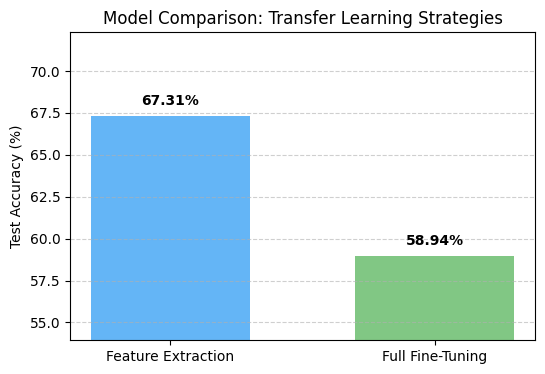

In [24]:
# --- Compare both models on test set ---
compare_models(model_feature=deeplabv3_model_1,
               model_finetune=deeplabv3_model_2,
               dataloader=valloader,
               device=device)

> **Expected Output:**
>
> ``` text
> ✅ Mean IoU: 68.62
> ✅ Mean IoU: 74.41
> ✅ Model Comparison Results:
> Feature Extraction Accuracy : 68.62%
> Full Fine-Tuning Accuracy   : 74.41%
>
> ```
> <img src="figs-lab5/iou.png" alt="Expected Output" width="20%">

**Reflection**

- How does accuracy and training speed differ between feature extraction and full fine-tuning?


Feature extraction tends to train faster because only the final classifier layers update during backpropagation, while the backbone remains frozen. This dramatically reduces computation and memory use, so each epoch finishes quickly. It also keeps performance stable when the dataset is small, since pretrained features already capture strong visual patterns. Full fine-tuning, on the other hand, updates all layers in the network. This gives the model more freedom to adapt to your dataset but also makes training slower and more computationally expensive. With more trainable weights, it needs more data to avoid overfitting, and the gains only appear when the target domain is noticeably different from ImageNet.

- If your dataset were large and domain-specific (e.g., medical images), which strategy would you prefer?  

If the dataset were large and domain-specific—say medical scans, satellite imagery, or agricultural pathology—full fine-tuning would be the better choice. Domain shifts like MRI or CT images have textures and structures that ImageNet features do not capture well. With enough data, the model benefits from relearning its low-level and mid-level features, improving fine details and ultimately producing higher accuracy. This is exactly where full fine-tuning shines: when you have thousands of examples and the visual world looks nothing like ImageNet.

- In what situations might feature extraction be preferable over full fine-tuning?

Feature extraction becomes preferable in low-data regimes or when computational resources are constrained. On small datasets, updating the entire network often causes overfitting because the model tries to memorize the training images. Freezing the backbone gives you fast, stable training and better generalization. It’s also the strategy of choice when you need quick prototyping, limited GPU memory, or you’re working with a domain that is still visually similar to ImageNet—like pets, vehicles, or everyday objects.

---
## <font color='#D85658'>4. Evaluation</font> ##

So far, we’ve focused on accuracy for classification. However, for **object detection** and **semantic segmentation**, more specialized metrics are used:

1. **Mean Average Precision (mAP)** — measures how well predicted bounding boxes overlap with ground truth boxes across different confidence thresholds.

$\mathrm{mAP}=\frac{1}{N} \sum_{i=1}^N \mathrm{AP}_i$

Each AP (Average Precision) is computed as the area under the Precision–Recall (PR) curve:

$\mathrm{AP}=\int_0^1 p(r) d r$

Where:
- $N$ = number of object classes
- $p(r)$ = precision as a function of recall

2. **Intersection-over-Union (IoU)** — measures how well predicted segmentation masks align with true object regions.

$\mathrm{IoU}=\frac{\left|A_{\text {pred }} \cap A_{\mathrm{gt}}\right|}{\left|A_{\text {pred }} \cup A_{\mathrm{gt}}\right|}$

where:

- $A_{pred}$ = set of pixels (or area) predicted as the object

- $A_{gt}$ = set of pixels (or area) belonging to the ground truth object

- $\cap$ = intersection (overlapping area)

- $\cup$ = union (combined area of prediction and ground truth)

Interpretation:

- IoU = 1 $\rightarrow$ perfect overlap

- IoU = 0 $\rightarrow$ no overlap

In this exercise, you’ll implement simplified versions of both metrics to understand their core concepts.

> ### <mark style="background-color: cyan;">Exercise 11:</mark> Simplified Mean Average Precision (mAP) for Object Detection

We’ll simulate a small set of bounding box predictions and compute IoU-based precision at different thresholds, then average over all predictions to get a simple mAP estimate.

In [25]:
def compute_iou(boxA, boxB):
    """
    Compute Intersection-over-Union (IoU) between two bounding boxes.
    Each box = [x1, y1, x2, y2]
    """
    # Compute intersection
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    ### START CODE ###
    interArea = max(0, xB - xA) * max(0, yB - yA)
    # Compute union
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea
    ### END CODE ###

    return interArea / unionArea if unionArea > 0 else 0


In [26]:
def compute_map(pred_boxes, gt_boxes, iou_threshold=0.5):
    """
    Compute a simplified mean Average Precision (mAP) metric.
    pred_boxes and gt_boxes are lists of bounding boxes for one image.
    """
    matched = set()
    tp, fp = 0, 0

    for pred in pred_boxes:
        best_iou = 0
        best_gt = -1
        for i, gt in enumerate(gt_boxes):
            iou = compute_iou(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_gt = i
        if best_iou >= iou_threshold and best_gt not in matched:
            ### START CODE ###
            tp = tp + 1
            ### END CODE ###
            matched.add(best_gt)
        else:
            ### START CODE ###
            fp = fp + 1
            ### END CODE ###

    ### START CODE ###
    fn = len(gt_boxes) - tp
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    ap = (precision + recall) / 2
    ### END CODE ###
    return ap


In [27]:
# --- Example: simulate predictions and ground truths ---
pred_boxes = [[50, 50, 200, 200], [30, 40, 100, 150]]  # predicted boxes
gt_boxes = [[48, 60, 198, 190]]  # ground truth

# --- Compute mAP at IoU threshold 0.5 ---
mAP = compute_map(pred_boxes, gt_boxes, iou_threshold=0.5)
print(f"Simplified mAP@0.5: {mAP:.3f}")

Simplified mAP@0.5: 0.750


> **Expected Output:**
>
> ``` text
> Simplified mAP@0.5: 0.750
> ```

> ### <mark style="background-color: cyan;">Exercise 12:</mark> Compute IoU for Semantic Segmentation

Now we’ll calculate IoU for segmentation masks, which measures how much the predicted region overlaps with the ground truth.

In [28]:
def compute_iou_mask(pred_mask, gt_mask):
    """
    Compute Intersection-over-Union for binary segmentation masks.
    pred_mask, gt_mask are numpy arrays of shape [H, W] with 0/1 values.
    """
    ### START CODE ###
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    iou_out = intersection / union if union > 0 else 0
    ### END CODE ###
    return iou_out


In [29]:
# --- Example: Create dummy segmentation masks ---
gt_mask = np.zeros((100, 100), dtype=np.uint8)
gt_mask[30:70, 30:70] = 1  # ground truth region

pred_mask = np.zeros((100, 100), dtype=np.uint8)
pred_mask[35:75, 35:75] = 1  # predicted region (slightly shifted)

# --- Compute IoU ---
iou_score = compute_iou_mask(pred_mask, gt_mask)
print(f"Segmentation IoU: {iou_score:.3f}")

Segmentation IoU: 0.620


---

## <font color='#D85658'>5. Exercises</font> ##

In this final section, you'll apply what you've learned to extend and analyze CNN models.  
You will:

1. Modify the CNN architecture and observe how performance changes.  
2. Train on a binary classification subset to explore precision–recall trade-offs.  
3. Discuss why high accuracy doesn’t always mean good performance.

These exercises will help you connect architectural design, dataset setup, and metric interpretation.

> ### <mark style="background-color: cyan;">Exercise 13:</mark> Object Detection and Semantic Segmentation on Custom Images

In this exercise, you’ll apply pretrained **object detection** and **semantic segmentation** models to your own real-world image — for example, a photo taken with your phone.

This demonstrates how the same models you trained and fine-tuned can be used directly for **real-world inference**.

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


📸 Upload your own image (e.g., a photo from your phone):


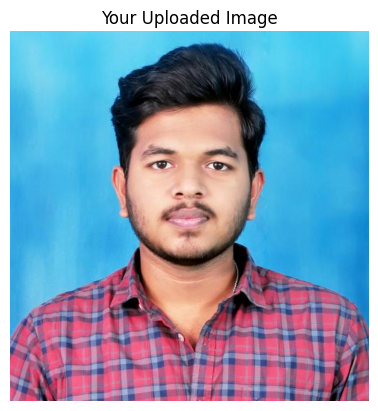

In [31]:
# --- Ask the student to upload an image ---
print("📸 Upload your own image (e.g., a photo from your phone):")

### START CODE ###
# --- Load the first uploaded image ---
image_path = "/content/drive/MyDrive/UCD/Autumn/Applied AI and Imaging/Tutorials/week -5/figs-lab5/passportpic.JPG"
img = Image.open(image_path).convert("RGB")
### END CODE ###


# --- Display the uploaded image ---
plt.imshow(img)
plt.title("Your Uploaded Image")
plt.axis("off")
plt.show()

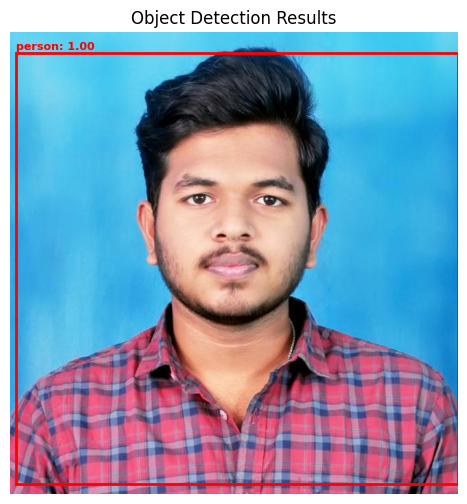

In [32]:
# --- Load pretrained object detection model ---
### START CODE ###
det_model = fasterrcnn_resnet50_fpn(weights="DEFAULT").to(device)  # Faster R-CNN model with a ResNet-50-FPN backbone
det_model.eval()
### END CODE ###

### START CODE ###
# --- Define preprocessing and class labels ---
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
])
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
coco_labels = weights.meta["categories"]
### END CODE ###

# --- Apply transformation ---
input_tensor = transform(img).to(device)
### START CODE ###
input_batch = input_tensor.unsqueeze(0)  # create batch dimension
### END CODE ###

# --- Run detection inference ---
with torch.no_grad():
    ### START CODE ###
    preds = det_model(input_batch)[0]
    ### END CODE ###

### START CODE ###
# --- Extract predicted boxes, labels, and confidence scores ---
boxes = preds["boxes"].cpu()
labels = preds["labels"].cpu()
scores = preds["scores"].cpu()
### END CODE ###

# --- Visualize detections ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img)
for box, label, score in zip(boxes, labels, scores):
    if score > 0.5:  # Confidence threshold
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{coco_labels[label]}: {score:.2f}", color='red', fontsize=8, weight='bold')
ax.set_title("Object Detection Results")
ax.axis("off")
plt.show()

> **Expected Output:**
>
> <img src="figs-lab5/det_cat.png" alt="Expected Output" width="20%">

> ### <mark style="background-color: cyan;">Exercise 13:</mark> Binary Fine-Tuning — "Car" vs "Not Car"

In this exercise, you’ll:
1. Create a **binary classification dataset** from CIFAR-10 (“car” vs all other classes).  
2. Fine-tune a pretrained **ResNet-18** model on this binary dataset.  
3. Experiment with hyperparameters like **learning rate** and **layer freezing**, then compare performance (accuracy, loss curves).

#### Prepare a Binary Dataset (Car vs Not-Car)

In [33]:
### START CODE ###
from torchvision import datasets, transforms

# --- Define preprocessing transformations ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),              # resize (128,128)
    transforms.ToTensor(),                      # to tensor
    transforms.Normalize((0.5, 0.5, 0.5),       # Normalize
                         (0.5, 0.5, 0.5))
])
### END CODE ###

# --- Load CIFAR-10 dataset ---
full_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
full_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# --- Filter dataset to create "Car" vs "Not Car" binary classification ---
car_class = 1  # CIFAR-10 label for "automobile"

### START CODE ###
# --- Lazy binary dataset wrapper ---
class BinaryCIFAR10(torch.utils.data.Dataset):
    def __init__(self, dataset, car_class=1):
        self.dataset = dataset
        self.car_class = car_class

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, (1 if label == car_class else 0)

# Wrap datasets (lazy, no memory explosion)
train_data = BinaryCIFAR10(full_train)
test_data = BinaryCIFAR10(full_test)
### END CODE ###

### START CODE ###
# --- Subset to make the dataset smaller ---
train_subset_idx = random.sample(range(len(train_data)), 1000)  # train size = 1000
test_subset_idx = random.sample(range(len(test_data)), 500)     # test size = 500
### END CODE ###

train_subset = torch.utils.data.Subset(train_data, train_subset_idx)
test_subset = torch.utils.data.Subset(test_data, test_subset_idx)

### START CODE ###
# --- DataLoaders ---
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
testloader = DataLoader(test_subset, batch_size=64, shuffle=False)
### END CODE ###

print(f"✅ Small Binary Dataset Ready!")
print(f"Training samples: {len(train_subset)}, Test samples: {len(test_subset)}")


✅ Small Binary Dataset Ready!
Training samples: 1000, Test samples: 500


> **Expected Output:**
>
> Files already downloaded and verified
>
> Files already downloaded and verified
>
> ✅ Small Binary Dataset Ready!
>
> Training samples: 1000, Test samples: 500
>

#### Load and Modify a Pretrained ResNet-18

In [34]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

### START CODE ###
# --- Load pretrained ResNet-18 model ---
weights = ResNet18_Weights.DEFAULT
resnet_model = resnet18(weights=weights)
### END CODE ###

### START CODE ###
# --- Replace the final layer for binary classification ---
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)
### END CODE ###

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

print(resnet_model.fc)


Linear(in_features=512, out_features=2, bias=True)


> **Expected Output:**
>
> Linear(in_features=512, out_features=2, bias=True)
>

Feature Extraction (Freeze Backbone).

In [35]:
### START CODE (8 lines (4 for loops)) ###
# --- Freeze all convolutional layers (feature extractor) ---
for param in resnet_model.layer1.parameters(): param.requires_grad = False
for param in resnet_model.layer2.parameters(): param.requires_grad = False
for param in resnet_model.layer3.parameters(): param.requires_grad = False
for param in resnet_model.layer4.parameters(): param.requires_grad = False

for param in resnet_model.conv1.parameters(): param.requires_grad = False
for param in resnet_model.bn1.parameters(): param.requires_grad = False
for param in resnet_model.relu.parameters(): param.requires_grad = False
for param in resnet_model.maxpool.parameters(): param.requires_grad = False
### END CODE ###


### START CODE ###
criterion = nn.CrossEntropyLoss()  # Cross Entropy Loss
optimizer = torch.optim.Adam(resnet_model.fc.parameters(), lr=1e-3)  # Adam with learning rate = 1e-3
### END CODE ###


print("Training mode: Feature Extraction (Frozen Backbone)")

Training mode: Feature Extraction (Frozen Backbone)


#### Training Loop

In [36]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        progress = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        ### START CODE ###
        for inputs, labels in progress:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            progress.set_postfix(loss=loss.item())
        ### END CODE ###
        print(f"Epoch {epoch+1}: Loss={running_loss/len(dataloader):.4f}, Acc={100*correct/total:.2f}%")

train_model(resnet_model, trainloader, optimizer, criterion, num_epochs=5)


Epoch 1/5: 100%|██████████| 16/16 [00:01<00:00, 15.02it/s, loss=0.114]


Epoch 1: Loss=0.3868, Acc=87.30%


Epoch 2/5: 100%|██████████| 16/16 [00:01<00:00, 15.19it/s, loss=0.194]


Epoch 2: Loss=0.2657, Acc=91.50%


Epoch 3/5: 100%|██████████| 16/16 [00:01<00:00, 15.06it/s, loss=0.222]


Epoch 3: Loss=0.1965, Acc=92.20%


Epoch 4/5: 100%|██████████| 16/16 [00:01<00:00, 15.08it/s, loss=0.174]


Epoch 4: Loss=0.1594, Acc=94.00%


Epoch 5/5: 100%|██████████| 16/16 [00:01<00:00, 15.18it/s, loss=0.153]

Epoch 5: Loss=0.1408, Acc=95.00%


> **Expected Output:**
>
> Epoch 1/5: 100%|██████████| 32/32 [00:00<00:00, 67.21it/s, loss=0.126]
>
> Epoch 1: Loss=0.2598, Acc=91.00%
>
> Epoch 2/5: 100%|██████████| 32/32 [00:00<00:00, 141.88it/s, loss=0.142]
>
> Epoch 2: Loss=0.1579, Acc=93.60%
>
> Epoch 3/5: 100%|██████████| 32/32 [00:00<00:00, 142.32it/s, loss=0.928]
>
> Epoch 3: Loss=0.1482, Acc=94.40%
>
> Epoch 4/5: 100%|██████████| 32/32 [00:00<00:00, 143.08it/s, loss=0.439]
>
> Epoch 4: Loss=0.1206, Acc=96.00%
>
> Epoch 5/5: 100%|██████████| 32/32 [00:00<00:00, 156.80it/s, loss=0.169]
>
> Epoch 5: Loss=0.1055, Acc=96.30%

#### Evaluate and Compare

In [37]:
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    ### START CODE ###
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    ### END CODE ###
    print(f"✅ Test Accuracy: {acc:.2f}%")
    return acc

evaluate_model(resnet_model, testloader)


✅ Test Accuracy: 91.00%


91.0

> **Expected Output:**
>
> ✅ Test Accuracy: 92.60%
>

> ### <mark style="background-color: cyan;">Exercise 15:</mark> Experiment with small changes and compare performance.

**Try the following experiments:**

1. Change the learning rate (`1e-3`, `1e-4`, `5e-5`) and observe how convergence changes.
2. Try freezing **only the first few layers** (e.g., `layer1`–`layer2`) instead of all.
3. Train for more epochs — do you see overfitting?
4. Replace “car” with another CIFAR-10 class (e.g., “dog” vs “not dog”).
5. Plot training and validation accuracy curves for comparison.

#### Try freezing **only the first few layers** (e.g., `layer1`–`layer2`) instead of all.

In [38]:
### START CODE ###
# --- Load pretrained ResNet-18 model ---
weights = ResNet18_Weights.DEFAULT
resnet_model_few_layers = resnet18(weights=weights)

# --- Replace the final layer for binary classification ---
num_features = resnet_model_few_layers.fc.in_features
resnet_model_few_layers.fc = nn.Linear(num_features, 2)
### END CODE ###


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model_few_layers = resnet_model_few_layers.to(device)

print(resnet_model_few_layers.fc)

Linear(in_features=512, out_features=2, bias=True)


> **Expected Output:**
>
> Linear(in_features=512, out_features=2, bias=True)
>

In [39]:
### START CODE ###
# --- Freeze all convolutional layers (feature extractor) ---
for p in resnet_model_few_layers.layer1.parameters(): p.requires_grad = False
for p in resnet_model_few_layers.layer2.parameters(): p.requires_grad = False
for p in resnet_model_few_layers.conv1.parameters(): p.requires_grad = False
for p in resnet_model_few_layers.bn1.parameters(): p.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,
                                    resnet_model_few_layers.parameters()), lr=1e-3)
### END CODE ###


print("Training mode: Feature Extraction (Frozen layers 1 & 2)")

Training mode: Feature Extraction (Frozen layers 1 & 2)


#### Training Loop

In [40]:
train_model(resnet_model_few_layers, trainloader, optimizer, criterion, num_epochs=5)

Epoch 1/5: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s, loss=0.185]


Epoch 1: Loss=0.3291, Acc=87.50%


Epoch 2/5: 100%|██████████| 16/16 [00:01<00:00, 12.48it/s, loss=0.0285]


Epoch 2: Loss=0.0597, Acc=97.70%


Epoch 3/5: 100%|██████████| 16/16 [00:01<00:00, 10.74it/s, loss=0.0122]


Epoch 3: Loss=0.0391, Acc=98.80%


Epoch 4/5: 100%|██████████| 16/16 [00:01<00:00, 11.11it/s, loss=0.00141]


Epoch 4: Loss=0.0191, Acc=99.50%


Epoch 5/5: 100%|██████████| 16/16 [00:01<00:00, 13.81it/s, loss=0.00649]

Epoch 5: Loss=0.0096, Acc=99.80%


> **Expected Output:**
>
> Epoch 1/5: 100%|██████████| 32/32 [00:00<00:00, 102.48it/s, loss=0.53]  
>
> Epoch 1: Loss=0.3139, Acc=90.30%
>
> Epoch 2/5: 100%|██████████| 32/32 [00:00<00:00, 130.56it/s, loss=0.0975]
>
> Epoch 2: Loss=0.1724, Acc=93.10%
>
> Epoch 3/5: 100%|██████████| 32/32 [00:00<00:00, 130.65it/s, loss=0.0271]
>
> Epoch 3: Loss=0.1409, Acc=95.00%
>
> Epoch 4/5: 100%|██████████| 32/32 [00:00<00:00, 124.39it/s, loss=0.0352]
>
> Epoch 4: Loss=0.1386, Acc=94.30%
>
> Epoch 5/5: 100%|██████████| 32/32 [00:00<00:00, 124.97it/s, loss=0.0671]
>
> Epoch 5: Loss=0.1001, Acc=96.70%

In [41]:
evaluate_model(resnet_model_few_layers, testloader)

✅ Test Accuracy: 96.00%


96.0

> **Expected Output:**
>
> ✅ Test Accuracy: 93.40%
>


---

## <font color='#D85658'>6. Discussion/Reflection</font> ##

* <u>Why is transfer learning effective for detection/segmentation?</u>


Transfer learning works almost like borrowing someone else’s well-worn mental map. A model pretrained on millions of images has already learned to see edges, shapes, textures, geometry, and object parts. These early visual features are surprisingly universal: a network trained on dogs, cars, and chairs becomes good at understanding structure in x-ray scans, satellite images, or road scenes. Detection and segmentation models benefit even more than classifiers because they must understand where things are, not just what they are. Starting from scratch would require enormous data, long training time, and a very careful optimization setup. With transfer learning, the backbone already knows how to parse visual patterns, and the model only needs to learn dataset-specific patterns, object layout, and label mappings. This dramatically boosts accuracy when datasets are small and makes training far more efficient.

* <u>How do detection and segmentation differ in output, complexity, and application?</u>

Detection and segmentation solve related but different problems. A detector predicts bounding boxes and class labels—essentially drawing rectangles around objects and naming them. This is faster and lighter because the model only outputs a handful of numbers per object (coordinates + class). Segmentation, however, produces a mask assigning every pixel to a class; it’s a full spatial understanding of the scene. That makes segmentation more computationally heavy, slower to train, and more memory-intensive. In application terms, detection is ideal when approximate object location is enough—autonomous driving perception stacks, wildlife monitoring, retail analytics, robotics grasping. Segmentation steps in when precise shapes matter—medical imaging, lane and drivable-area detection, agriculture mapping, background removal, and photo editing. They operate at different resolutions of meaning: detection shows where the object is, segmentation shows what shape it takes.